# Network Analysis Project - Karl Merisalu
<b>Problem:</b> Making sense of organisational reporting lines/structures when dealing with large organisations can be difficult and time consuming. 

One effective way to simplify understanding of organisational structures is to produce organisational charts and many large organisations have such systems in place to explore most frequently accessed reporting lines. For example personnel org charts. 

However, if one is in need of making sense of a network quickly where such a system is not in place, we face a problem and this notbook aims to tackle it.

This notebook provides a quick function to process through nodes and edges in a dataset and shows how to plot it in a simple hierarchical network chart.

### 1) Setting up the environment
We will first import all libraries we need to process data and plot the chart

In [1]:
# for data manipulation
import numpy as np
import pandas as pd

# for creating nodes, edges and list of paths between nodes
import networkx as nx

# for plotting the network chart
import anytree
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
from anytree.dotexport import RenderTreeGraph
from graphviz import Source


### 2) Defining functions to process raw data
<b>2.1</b> First, we define a function which takes a list input (all paths from the parent node to all child nodes) and converts the list into suitable format for plotting. We define this function first because it will be used by another function later on.

In [2]:
def list_to_anytree(lst):
        root_name = lst[0][0]
        root_node = Node(root_name)
        for branch in lst:
            parent_node = root_node
            assert branch[0] == parent_node.name
            for cur_node_name in branch[1:]:
                cur_node = next(
                    (node for node in parent_node.children if node.name == cur_node_name),
                    None,
                )
                if cur_node is None:
                    cur_node = Node(cur_node_name, parent=parent_node)
                parent_node = cur_node
        return root_node

<b>2.2</b> Second, we define a function which iterates through csv data and creates list of paths from the parent node to all child nodes. Detailed description of how the function works is in code as comments:

In [3]:
def org_chart(df, parent_col, child_col, parent, depth=None): 

# adding comments below to describe how to use the function
    """Function inputs: df=dataset (dataframe), parent_col="name of parent column in dataset", 
    child_col= name of child column in dataset, parent="root node in parent column",
    depth=max number of children (default=None) """    

# Below block of code: 1) creates an empty list (working_list), 2) then iterates through all columns in the initial dataset searching for 
# user inputted root/parent node in the parent column, 3) once we have root node, we add it together with it's child node
# into created empty list ([parent, child]). As a result we get a complete list of root node and its child node pairs.

    working_list = [] 
    for i,j in df.iterrows(): 
         if df[parent_col][i] == parent: 
            working_list.append([df[parent_col][i], df[child_col][i]]) 

# Below block of code: 1) iterates through populated working_list, 2) takes the child of the root node and checks if the child has any 
# grandchildren in the initial dataset (df), 3) if grandchildren exist, we add a the pair on the bottom of working_list 
# as [child, grandchild]. We repeat this process until there are no more children to add. As a result we have a 
# complete list of parent-child relationships existing (only) below the root node.

    for i,j in working_list: 
        for k,l in df.iterrows(): 
            if df[parent_col][k] == j:
                working_list.append([j, df[child_col][k]])

# We need to have complete paths from root to the very grand of children instead of 
# pairwise relationships, as we have now. We can achieve this with networkx library.

# To use nx library, we first define all nodes, which is essentially unique values from working_list 
    nodes = set(x for l in working_list for x in l)

# Next we define that we're dealing with a directed graph (DiGraph) - important
# to determine parent and child to avoid vice versa relationship.
    DG = nx.DiGraph()
    
# Adding all nodes to nx.DiGraph()
    DG.add_nodes_from(nodes)

# Next we add edges (relationship between nodes) to nx.DiGraph()
    for i,j in working_list:
        DG.add_edge(i, j)

# Creating a new list for full paths between root and child nodes.
    path_list = []

# nx.all_simple_paths gives us a path in a list form, from source (root/parent) to target node. 
# The loop below iterates through all nodes and adds all created paths from source to the end node,
# to path_list
 
    for i in nodes:
        for path in nx.all_simple_paths(DG, source=parent, target=i, cutoff=depth):
            path_list.append(path)

# We list_to_anytree function and feed it the path list we just created.
    chart_data = list_to_anytree(path_list)

# Returning suitably formatted chart_data to create a dotfile and then plot.
    return chart_data

### 3) Importing data
Next, we import raw data that we're going to work with. 
In many cases, the dataset we can pull from systems, is not quite what we need, so for this purpose I've created a somewhat messy dataset based on Google's (Alphabet) legal entity structure to better show the functionality of this code.

In [4]:
df = pd.read_csv('alphabet4.csv')
df.head()

,test col 1,test col 2,test col 3,subsidiary,test col 4,test col 5,test col 6,test col 7,test col 8,test col 9,parent,test col 10
0,x,y,z,nest,a,b,-,b,a,d,alphabet,3.0
1,x,y,z,access and energy,a,b,-,b,a,d,alphabet,4.0
2,x,y,z,verily,a,b,-,b,a,d,alphabet,5.0
3,x,z,z,calico,a,b,-,b,a,d,alphabet,6.0
4,x,z,z,side walk labs,a,b,-,b,a,d,alphabet,7.0


<b>Above:</b> we are only interested in column 'parent' and column 'subsidiary'. 

### 4) Data processing
We're going to use org_chart function which we defined in step 2 to process raw data. But first, let's inspect the function to see which variables to select

In [5]:
org_chart?

Now that we have info about the function we call it with following inputs and save it into a new variable tree_chart: 
<br><b>dataset</b> = df, 
<br><b>parent column</b> = 'parent', 
<br><b>child column</b> = 'subsidiary', 
<br><b>root node of interest</b> = 'google' <i>(note not 'alphabet' in this example)</i>, 
<br><b>max children/depth</b> = None <i>(to see the path all the way down)</i>

In [6]:
tree_chart = org_chart(df, 'parent', 'subsidiary', 'google', None) # use depth = None for max chart depth

### 5) Plotting the org chart
To plot the chart we first create a dotfile out of treechart, which according to http://www.graphviz.org/ is: <i>dot - "hierarchical" or layered drawings of directed graphs. This is the default tool to use if edges have directionality.</i>

Then as a final step we plot the chart from dotfile using graphviz Source.

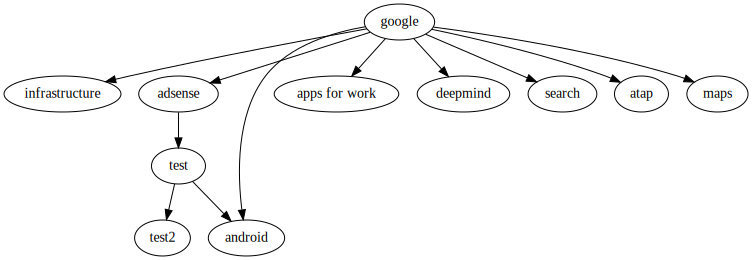

In [7]:
DotExporter(tree_chart).to_dotfile('orgchart.dot')

Source.from_file('orgchart.dot')

### 6) Conclusion
The chart above helps us get a quick high level overview of Google's (or any other directional network's) org chart. Higher level parents are on the up and subsidiaries/childs are portrayed down. Root node or ultimate parent is 'google' in this case. 

This code can save us a lot of time when trying making sense of directional networks as opposed to analysing raw pairwise data manually (with excel for example).
 
Although the chart conveniently portrays well formatted org chart, there are several further developments that could be considered.

<b> Further research and improvements:</b> 
<br><b>1) Infinite loop paths:</b> the org_chart function will break should there be a direct or indirect loop in the dataset (parent referring to child and child referring back to the parent). To fix this, org_chart's loop should verify if a given pair already exists in the working_list. If adding a new node pair to the list causes a duplication then the loop should stop and instead move on to the next iteration.
<br><b>2) More advanced graphs/specifications:</b> The plot could be used to deliver more information than just the network structure. For example in the case of Google, it would be interesting to see which of the companies are aligned to 1) developing hardware, 2) developing software, 3) industry alignment such as quantum computing or industry alignment such as medical research and etc. Such node features could be marked with different colours of the chart.